In [1]:
#### 10% shapeError and scan 1/m2_q +- 1e-3

In [2]:
from Functions import *
import winsound

# Preliminary

In [3]:
def define_beamline_normal(
    E0, m1_p=185.0, m1_q=-25.6, m2_p=None, m2_q=1e5,
    HHLM_type='2DCM', HHLM_offset=20e-3, pair_distance=200e-3,
    slit_width=3e-6, f1=10.0, f2=10.0,
    hkl1 = [1,1,1], alphaAsym1 = 0.0,
    hkl2 = [2,2,0], alphaAsym2 = 0.0,
    hkl3 = [5,5,5], alphaAsym3 = 15.0,
    shapeErrors=[None for i in range(6)],
    l_crystal=[1e-1 for i in range(6)],
    w_crystal = [5e-3 for i in range(6)]):
    
    z_s = 650

    # viewing point - upstream of monochromator
    im_input = optics.PPM('im_input', z=184+z_s, FOV=5e-3, N=512)
    
    Telescope_devices = define_Telescope(E0, m1_p=m1_p, m1_q=m1_q, m2_p=m2_p, m2_q=m2_q)
    
    if HHLM_type == '2DCM':
        HHLM_devices = define_HHLM_2DCM(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    elif HHLM_type == 'Zigzag':
        HHLM_devices = define_HHLM_Zigzag(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    
    HRM_devices = define_HRM(E0, f1=f1, f2=f2, slit_width=slit_width,
                            hkl=hkl3, alphaAsym=alphaAsym3,
                            shapeErrors=shapeErrors,
                            l_crystal=l_crystal,
                            w_crystal=w_crystal)

    all_devices = [im_input] + Telescope_devices + HHLM_devices + HRM_devices
    
    mono_beamline = beamline.Beamline(all_devices, ordered=True)
    return all_devices, mono_beamline

### 1. common simulation parameters

In [4]:
##### ''' Beam parameters '''
N = 1024          # number of sampling points
E0 = 9481        # photon energy [eV]

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
    'photonEnergy': E0,
    'N': N,
    'sigma_x': 23e-6,
    'sigma_y': 23e-6,
    'rangeFactor': 5,
    'scaleFactor': 10,
    'z_source': 650-26
}

##### common simulation parameters
m1_p = 185.0; m1_q = -58.0
m2_q = 52916240.294142954
f1 = 10.0; f2 = 10.0            # f1: crystal-mirror distance, f2: mirror focal distance

HHLM_type = 'Zigzag'              # 2DCM or Zigzag
HHLM_offset=20e-3
pair_distance=200e-3
hkl1 = [1,1,1]; alphaAsym1 = 9.0    # asymmetry angle for the 1st pair of HHLM crystal
hkl2 = [2,2,0]; alphaAsym2 = 16.9    # ````````````````````````2nd pair of HHLM crystal
hkl3 = [4,4,0]; alphaAsym3 = 15.0   # ````````````````````````2nd and 3rd HRM crystal

# list of crystals
crystals = np.array(['HHLM1', 'HHLM2', 'HHLM3', 'HHLM4', 'C1', 'C2']); n_crys = len(crystals)

##### I/O
dir_out = 'output/'; make_dir(dir_out)
dir_ev = dir_out + '{}eV/'.format(E0); make_dir(dir_ev)
dir_case = dir_ev + 'm2_q_optimization/'; make_dir(dir_case)

print('\nCWD:',dir_case)

dir_plot = dir_case+'{}_{}_{}/'.format(HHLM_type, hkl1[0]*100+hkl1[1]*10+hkl1[2],
                                      hkl2[0]*100+hkl2[1]*10+hkl2[2]); make_dir(dir_plot)
dir_plot += '{}_{}_deg_{}mm_offset/'.format(alphaAsym1, alphaAsym2, 1e3*HHLM_offset); make_dir(dir_plot)


path exists
path exists
path exists

CWD: output/9481eV/m2_q_optimization/
path exists
path exists


### 2. calculate crystal dimensions and slit width

In [5]:
%%capture capt

# simulation parameters for the normal condition
slit_width = 1e-1
shapeErrors = [None for i in range(6)]
l_crystal = [1e-1 for i in range(6)]
w_crystal = [5e-3 for i in range(6)]

mono_devices_calc, mono_beamline_calc = define_beamline_normal(E0,
                               m1_p=m1_p, m1_q=m1_q, m2_q=m2_q,
                               HHLM_type=HHLM_type,
                               HHLM_offset=HHLM_offset,
                               pair_distance=pair_distance,
                               slit_width=slit_width, f1=f1, f2=f2,
                               hkl1=hkl1, alphaAsym1=alphaAsym1,
                               hkl2=hkl2, alphaAsym2=alphaAsym2,
                               hkl3=hkl3, alphaAsym3=alphaAsym3,
                               shapeErrors=shapeErrors,
                               l_crystal=l_crystal,
                               w_crystal=w_crystal)

b1_calc = beam.Beam(beam_params=beam_params)
b2_calc = mono_beamline_calc.propagate_beamline(b1_calc)

In [6]:
# get crytal properties
beta0s = []; braggs = []; asyms = []
for device in mono_devices_calc:
    if device.name in crystals:
        beta0s.append(device.beta0)
        braggs.append(np.rad2deg(device.bragg))
        asyms.append(np.rad2deg(device.alphaAsym))

# calculate beam FWHM after each crystal
wx1, wy1 = mono_beamline_calc.im_after_HHLM1.beam_analysis(mono_beamline_calc.im_after_HHLM1.get_profile_x(), mono_beamline_calc.im_after_HHLM1.get_profile_y())[2:4]
wx2, wy2 = mono_beamline_calc.im_after_HHLM2.beam_analysis(mono_beamline_calc.im_after_HHLM2.get_profile_x(), mono_beamline_calc.im_after_HHLM2.get_profile_y())[2:4]
wx3, wy3 = mono_beamline_calc.im_after_HHLM3.beam_analysis(mono_beamline_calc.im_after_HHLM3.get_profile_x(), mono_beamline_calc.im_after_HHLM3.get_profile_y())[2:4]
wx4, wy4 = mono_beamline_calc.im_after_HHLM4.beam_analysis(mono_beamline_calc.im_after_HHLM4.get_profile_x(), mono_beamline_calc.im_after_HHLM4.get_profile_y())[2:4]
wx5, wy5 = mono_beamline_calc.im_after_C1.beam_analysis(mono_beamline_calc.im_after_C1.get_profile_x(), mono_beamline_calc.im_after_C1.get_profile_y())[2:4]
wx6, wy6 = mono_beamline_calc.im_after_C2.beam_analysis(mono_beamline_calc.im_after_C2.get_profile_x(), mono_beamline_calc.im_after_C2.get_profile_y())[2:4]
beam_size = np.array([wx1, wx2, wx3, wx4, wx5, wx6])    # FWHM

# crystal lengths (long) and widths (short) [m]
l_crystal = np.divide(beam_size*2, np.sin(beta0s))
w_crystal = np.array([wy1, wy2, wy3, wy4, wy5, wy6])*2

print('bragg angle: {}'.format(np.round(braggs,3)))
print('asymmetry: {}'.format(np.round(asyms,3)))
print('beam size: {} mm'.format(np.round(beam_size*1e3, 3)))
print('footprint: {} mm\n'.format(np.round(l_crystal*1e3/2,  3)))


# calculate slit width
slit_width = calc_slit_width(wx6*2, b2_calc.lambda0, mono_beamline_calc.mir1.q)
print('calculated slit width: {}um'.format(round(slit_width*1e6,2)))

if slit_width < 3e-6: slit_width = 3e-6
print('actual slit width: {}um\n'.format(round(slit_width*1e6,2)))

bragg angle: [12.043 19.916 19.91  12.037 42.928 42.928]
asymmetry: [ -9.  -16.9  16.9   9.    0.   15. ]
beam size: [ 8.845 99.271  8.841  1.162  1.119  0.601] mm
footprint: [ 24.641 165.684 167.648  21.876   1.644   1.284] mm

calculated slit width: 1.01um
actual slit width: 3.0um



### Beam profile for the perfect case

In [7]:
%%capture capt

mono_devices_p, mono_beamline_p = define_beamline_normal(E0,
                       m1_p=m1_p, m1_q=m1_q, m2_q=m2_q,
                       HHLM_type=HHLM_type,
                       HHLM_offset=HHLM_offset,
                       pair_distance=pair_distance,
                       slit_width=slit_width, f1=f1, f2=f2,
                       hkl1=hkl1, alphaAsym1=alphaAsym1,
                       hkl2=hkl2, alphaAsym2=alphaAsym2,
                       hkl3=hkl3, alphaAsym3=alphaAsym3,
                       shapeErrors=[None for i in range(6)],
                       l_crystal=l_crystal,
                       w_crystal=w_crystal)

screen_names = ['im_input', 'im_after_T1', 'im_after_T2', 'im_after_HHLM1', 'im_after_HHLM2', 'im_after_HHLM3', 'im_after_HHLM4',
    'im_after_C1','im_after_C2','im_before_MIR1','im_after_MIR1','im_focus','im_before_MIR2','im_after_MIR2','im_after_C3','im_out']

beam_params['photonEnergy'] = E0
pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True, spectral_width=9481e-3, N=150)
pulse.propagate(beamline=mono_beamline_p,screen_names=screen_names)


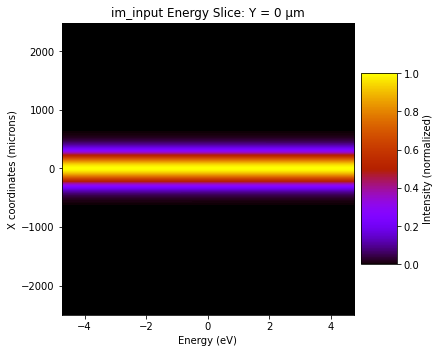

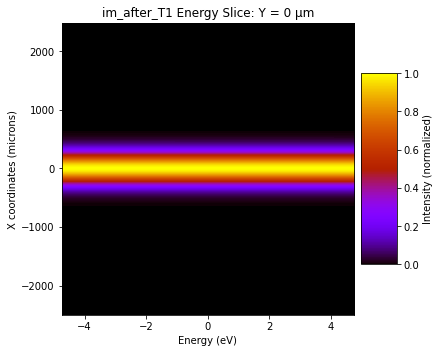

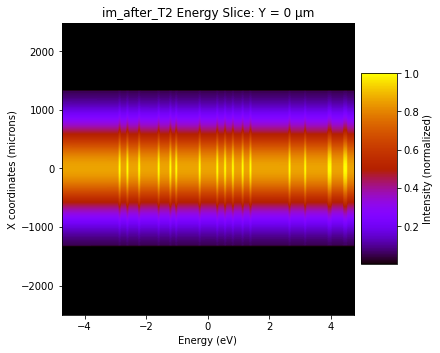

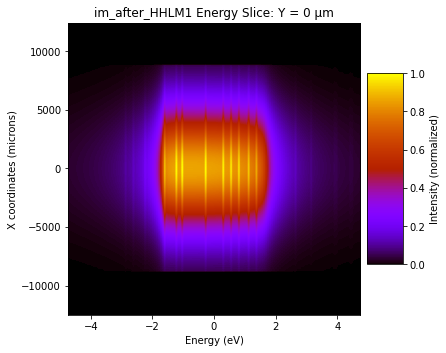

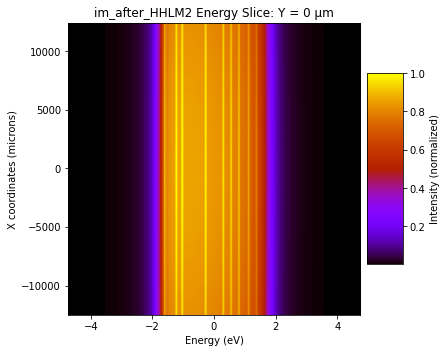

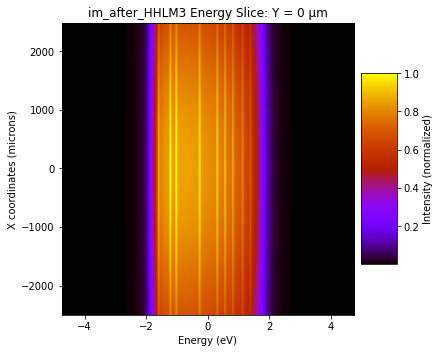

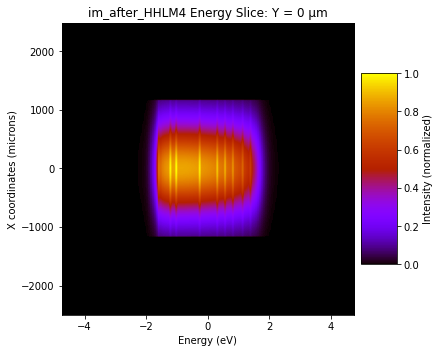

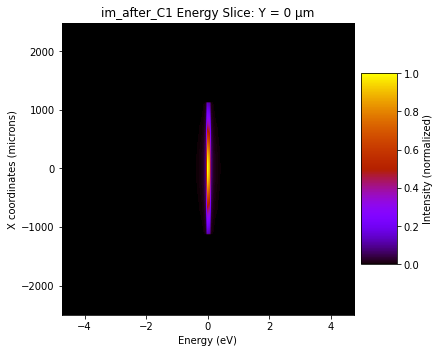

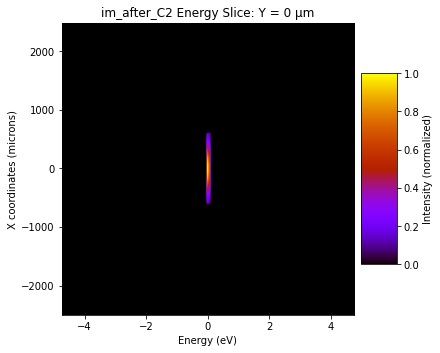

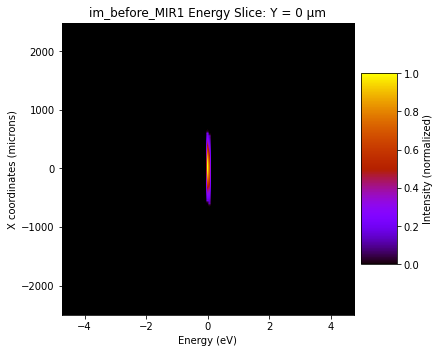

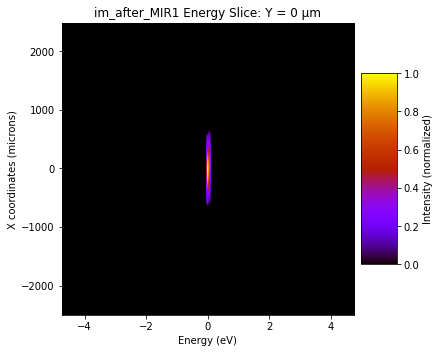

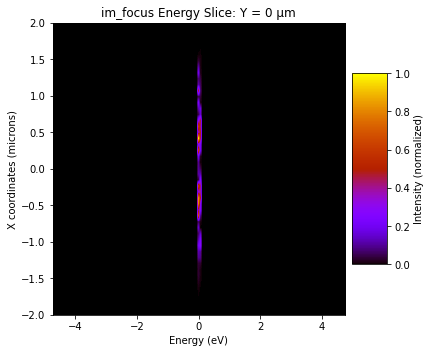

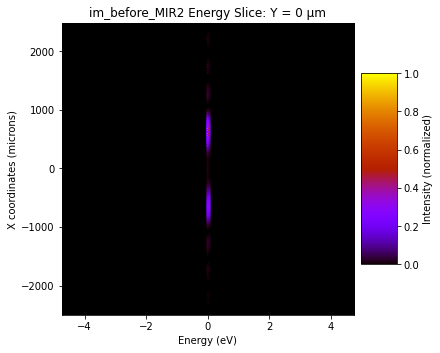

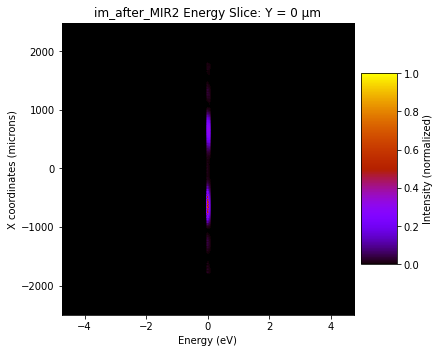

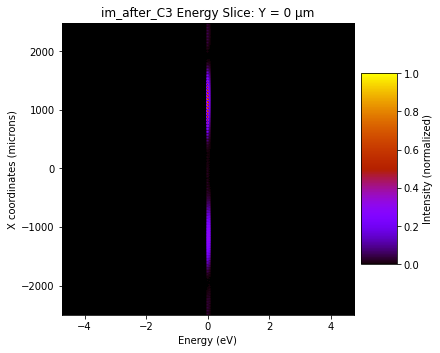

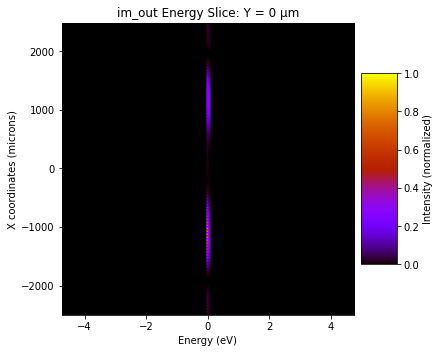

In [8]:
''' energy slices '''
for i,screen_name in enumerate(pulse.screens):
    try:
        pulse.imshow_energy_slice(screen_name)
    except:
        print(screen_name, 'failed')

In [9]:
# ''' diagnostics '''
# # output diagnostics
# c, pulse_duration0 = pulse.pulse_duration('im_out')
# pulse_tilt0 = pulse.pulsefront_tilt('im_out')
# spatial_chirp0 = pulse.spatial_chirp('im_out')
# energy_bandwidth0 = pulse.pulse_bandwidth('im_out')
# throughput0 = pulse.throughput('im_input','im_out')
# print('duration {}fs'.format(pulse_duration0))
# print('tilt {}fs/um'.format(pulse_tilt0))
# print('spatial chirp {}meV/um'.format(spatial_chirp0*1e3))
# print('bandwidth {}meV'.format(energy_bandwidth0*1e3))
# print('throughput {}%'.format(throughput0*1e2))
# np.savetxt(dir_plot+'diagnostics_value.txt',np.array([pulse_duration0, pulse_tilt0, spatial_chirp0*1e3, energy_bandwidth0*1e3]), delimiter=',')

# crystal bandwidths
bandwidth = np.zeros_like(crystals)
for i,crystal in enumerate(crystals):
    screen_name = 'im_after_{}'.format(crystal)
    bandwidth[i] = pulse.pulse_bandwidth(screen_name)
    print(crystal, bandwidth[i])


HHLM1 3.355
HHLM2 3.393
HHLM3 3.363
HHLM4 3.092
C1 0.293
C2 0.174


In [10]:
import winsound
winsound.Beep(1500, 3000)